In [1]:
# design the full graph for integration of 3 different tools
import os
from dotenv import load_dotenv
from pyprojroot import here

load_dotenv()

True

Set the environment variables

In [2]:
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")

# Initialize the tools

### 1.1 Rag Tool Design for unstructured data

In [3]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool

EMBEDDING_MODEL = "text-embedding-3-small"
VECTORDB_DIR = "data/airline_policy_vectordb"
K = 2

@tool
def lookup_policy(query: str)->str:
    """Consult the company policies to check whether certain options are permitted."""
    vectordb = Chroma(
    collection_name="rag-chroma",
    persist_directory=str(here(VECTORDB_DIR)),
    embedding_function=OpenAIEmbeddings(model=EMBEDDING_MODEL)
    )
    docs = vectordb.similarity_search(query, k=K)
    return "\n\n".join([doc.page_content for doc in docs])

print(lookup_policy)

name='lookup_policy' description='Consult the company policies to check whether certain options are permitted.' args_schema=<class 'langchain_core.utils.pydantic.lookup_policy'> func=<function lookup_policy at 0x7436755e2d40>


In [4]:
# VECTORDB_DIR = "data/airline_policy_vectordb"
# K=2

# vectordb = Chroma(
#     collection_name="rag-chroma",
#     persist_directory=str(here(VECTORDB_DIR)),
#     embedding_function=EMBEDDING_MODEL
# )
# print("Number of vectors in vectordb:",
#       vectordb._collection.count(), "\n\n")


In [5]:
lookup_policy.invoke("can I cancel my ticket?")

"conditions of your ticket to make sure you're eligible for a refund.\nSwiss Air Cancellation Fees The cancellation fees for Swiss Air flights may vary depending on the type of ticket you have\npurchased. The airline offers three different types of tickets, which are:\nFlex Ticket - This ticket offers the most flexibility and allows passengers to make changes or cancel their flight without\nincurring any additional fees. Standard Ticket - This ticket offers some flexibility but charges a fee for changes and\ncancellations. The fee for cancelling a standard ticket can range from 100 to 250 CHF, depending on the route and time\nof cancellation. Economy Ticket - This ticket offers the least flexibility and charges a fee for any changes or cancellations.\nThe fee for cancelling an economy ticket can range from 150 to 350 CHF, depending on the route and time of\ncancellation. It is important to note that the fees listed above are subject to change and may vary depending on the\nspecific tic

### 1.2 Search tool design

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [7]:
search_tool = TavilySearchResults(max_results=2)
search_tool.invoke("what is latest news of todays from india")

[{'url': 'https://timesofindia.indiatimes.com/india/timestopten.cms',
  'content': 'With legal sand extraction unable to meet demand, illegal mining has surged, targeting riverbeds and resulting in environmental degradation and threats to human life, reports ToI. In states like Madhya Pradesh and Haryana, villagers, police officers, and government officials who oppose illegal sand mining face violent reprisals. In 2022, Haryana witnessed 12 sand mining-related attacks, including the murder of DSP Surender Singh, who was run over by a dumper truck during an illegal mining investigation, with six suspects arrested and the case still ongoing. Follow news that matters to you in real-time. A fuel tanker collided head-on with another truck in Nigeria on Sunday causing an explosion that killed at least 48 people, the country’s emergency response agency said.'},
 {'url': 'https://www.ndtv.com/india',
  'content': 'Before Poll Panel, Sharad Pawar Camp Questions Premise Of Dispute In NCP\nThe Sh

In [8]:
### 1.3 Sql Agent tool design 
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

# SQL AGent chain

In [9]:
sqldb_directory = here("../data/Chinook.db")

sql_llm = ChatOpenAI(model="gpt-3.5-turbo",temperature = 0)

In [10]:
system_role = """Given the following user question, corresponding SQL query, and SQL result, answer the user question.\n
    Question: {question}\n
    SQL Query: {query}\n
    SQL Result: {result}\n
    Answer:
    """

In [11]:
sqldb_directory = "/media/brainwired/D/BW_ML/01_AUG_FARM_TEST/study/01_pdf_mysql_ai_agent/RAG_AGENT_FOR_QA_FROM_STRUCTURAL_UNSTRUCTURAL_DATA/data/Chinook.db"

db = SQLDatabase.from_uri(f"sqlite:///{sqldb_directory}")

excute_query = QuerySQLDataBaseTool(db=db)

write_query = create_sql_query_chain(sql_llm,db)

answere_prompt = PromptTemplate.from_template(system_role)

answere = answere_prompt |sql_llm| StrOutputParser()


chain = (RunnablePassthrough.assign(
    query=write_query).assign(result=itemgetter("query")| excute_query) |answere
    )


In [12]:
db.run("SELECT * FROM aLBUM")

'[(1, \'For Those About To Rock We Salute You\', 1), (2, \'Balls to the Wall\', 2), (3, \'Restless and Wild\', 2), (4, \'Let There Be Rock\', 1), (5, \'Big Ones\', 3), (6, \'Jagged Little Pill\', 4), (7, \'Facelift\', 5), (8, \'Warner 25 Anos\', 6), (9, \'Plays Metallica By Four Cellos\', 7), (10, \'Audioslave\', 8), (11, \'Out Of Exile\', 8), (12, \'BackBeat Soundtrack\', 9), (13, \'The Best Of Billy Cobham\', 10), (14, \'Alcohol Fueled Brewtality Live! [Disc 1]\', 11), (15, \'Alcohol Fueled Brewtality Live! [Disc 2]\', 11), (16, \'Black Sabbath\', 12), (17, \'Black Sabbath Vol. 4 (Remaster)\', 12), (18, \'Body Count\', 13), (19, \'Chemical Wedding\', 14), (20, \'The Best Of Buddy Guy - The Millenium Collection\', 15), (21, \'Prenda Minha\', 16), (22, \'Sozinho Remix Ao Vivo\', 16), (23, \'Minha Historia\', 17), (24, \'Afrociberdelia\', 18), (25, \'Da Lama Ao Caos\', 18), (26, \'Acústico MTV [Live]\', 19), (27, \'Cidade Negra - Hits\', 19), (28, \'Na Pista\', 20), (29, \'Axé Bahia 200

In [13]:
@tool
def query_sqldb(query):
    """
    Query the chinook Database it has the music and busines related information 
    input should be search query
    """
    response = chain.invoke({'question':query})
    return response

In [14]:
message = "total number of the table in databases with names thier names?"
response = query_sqldb.invoke(message)
print(response)

The total number of tables in the database with the name "Album" is 11.


In [15]:
response

'The total number of tables in the database with the name "Album" is 11.'

Wrap the tools into list

In [16]:
tools = [search_tool, lookup_policy, query_sqldb]

In [17]:
# load the the LLM for primary agen and bind ot with the tools

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

# 2 . INITIALIZE THE GRAPH STATE

THIS WILL USE DEFINE THE OUR STATEGRAPHS's STATE AS TYPED DICTIONARY CONTAINING AN APPEDN-ONLY LIST OF MESSAGE THESE MESSAGES FORM THE CHAT HISTORY WHICH IS ALL THE STATE OUR CHATBOT NEEDS

In [18]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# define the Graph Nodes

#### 3.1 First node :chatbot

In [19]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next, we need to create a function that will run the tools when they are needed. To do this, we'll add the tools to a new node.

In the example below, we'll build a BasicToolNode. This node will check the latest message and, if it contains a request to use a tool, it will run the appropriate tool. This works because many language models (like Anthropic, OpenAI, and Google Gemini) support tool usage.

#### 3.2 Second node: BasicToolNode that runs the appropriate tool based on the primary agent's output

In [20]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[search_tool, lookup_policy, query_sqldb])
graph_builder.add_node("tools", tool_node)

4. Define the entry point and graph edges

#### approch 1

In [21]:
# from typing import Literal


# def route_tools(

#     state: State,
# ) -> Literal["tools", "__end__"]:
#     """
#     Use in the conditional_edge to route to the ToolNode if the last message
#     has tool calls. Otherwise, route to the end.
#     """
#     if isinstance(state, list):
#         ai_message = state[-1]
#     elif messages := state.get("messages", []):
#         ai_message = messages[-1]
#     else:
#         raise ValueError(f"No messages found in input state to tool_edge: {state}")
#     if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
#         return "tools"
#     return "__end__"


# # The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# # it is fine directly responding. This conditional routing defines the main agent loop.
# graph_builder.add_conditional_edges(
#     "chatbot",
#     route_tools,
#     # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
#     # It defaults to the identity function, but if you
#     # want to use a node named something else apart from "tools",
#     # You can update the value of the dictionary to something else
#     # e.g., "tools": "my_tools"
#     {"tools": "tools", "__end__": "__end__"},
# )
# # Any time a tool is called, we return to the chatbot to decide the next step
# graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge(START, "chatbot")

Approach 2

In [22]:
from langgraph.graph import END, MessagesState
from typing import Literal

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    should_continue,
    ["tools", END],
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

## 5. Compile the graph

In this step, we can add a memory to our graph as well.

In [23]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

### 5.1 Plot the compiled graph

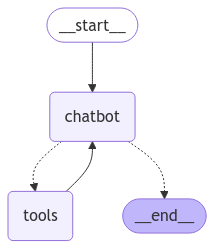

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
save = False

if save:
    from PIL import Image as PILImage
    import io
    # Assuming graph.get_graph().draw_mermaid_png() returns PNG binary data
    try:
        # Generate the PNG image from the graph
        png_data = graph.get_graph().draw_mermaid_png()
        
        # Convert the binary data into an image
        img = PILImage.open(io.BytesIO(png_data))
        
        # Save the image locally with 300 DPI
        img.save('output_image.png', 'PNG', dpi=(300, 300))
        
        print("Image saved successfully with 300 DPI.")
    except Exception as e:
        print(f"Error: {e}")

## 6. Execute the graph

In [26]:
config = {"configurable": {"thread_id": "1"}}


#### Approach 1: Print all the steps the the system goes through ti get the final output

In [27]:
user_input = "Hi there! My name is Farzad."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Farzad.
================================== Ai Message ==================================

Hello Farzad! How can I assist you today?


In [28]:
from langchain_core.messages import HumanMessage
user_input = "Hi there! My name is Farzad."

# Use the Runnable
final_state = graph.invoke(
    {"messages": [HumanMessage(content=user_input)]},
    config=config
)
final_state["messages"][-1].content

'Hello again, Farzad! How can I help you today?'

In [29]:
user_input = "Can I cancel my ticket 10 hours before the flight answere me very specific?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can I cancel my ticket 10 hours before the flight answere me very specific?
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_7UKpdbMZcnILJXs6ynatMHYh)
 Call ID: call_7UKpdbMZcnILJXs6ynatMHYh
  Args:
    query: ticket cancellation policy 10 hours before flight
================================= Tool Message =================================
Name: lookup_policy

"hour cancellation policy that allows passengers to cancel their flights within 24 hours of booking at +1-877-507-7341\nwithout penalty. This policy applies to all fare types, including non-refundable tickets. If you cancel your Swiss Airlines\nflight within 24 hours of booking, you'll receive a full refund of your ticket price.\nHow to Cancel Swiss Airlines Flight within 24 Hours? If you need to cancel your Swiss Airlines flight within 24 hours of\nbooking, you can do so easily online

In [30]:
user_input = "Right now Harris vs. Trump Presidential Debate is being boradcasted. I want the youtube link to this debate"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Right now Harris vs. Trump Presidential Debate is being boradcasted. I want the youtube link to this debate
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1nIxAvJEHOFQOM8wgDmL9jCr)
 Call ID: call_1nIxAvJEHOFQOM8wgDmL9jCr
  Args:
    query: Harris vs Trump Presidential Debate YouTube link
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/live/VgsC_aBquUE", "content": "Watch live coverage as Vice President Kamala Harris and former President Donald Trump face off in their first presidential debate in Philadelphia.Follow live"}, {"url": "https://www.youtube.com/watch?v=kRh6598RmHM", "content": "#election #election2024 #donaldtrump #kamalaharris #abcnews President Donald Trump and Vice President Kamala Harris are set to face off in t